<a href="https://colab.research.google.com/github/mayaraperroni9/datascience/blob/main/AutoEncoder_Multi_Layer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder com Multi Layer Perceptron


##Importação das bibliotecas necessárias

In [ ]:
pip install graphviz python-graphviz

ERROR: Could not find a version that satisfies the requirement python-graphviz (from versions: none)
ERROR: No matching distribution found for python-graphviz


In [ ]:
#bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from graphviz import Digraph
from IPython.display import display
from sklearn.metrics import mean_squared_error
import pydot
from IPython.display import Image
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

## Criando os dados sintéticos

Nesta etapa, estamos gerando dados sintéticos aleatórios para demonstração. Esses dados serão usados para treinar o autoencoder.

In [ ]:
# Dados sintéticos
# Vamos criar dados sintéticos para demonstração
tamanho = 1000
dimensao = 200

# Gerar dados sintéticos aleatórios
dados = np.random.rand(dimensao, tamanho)

In [ ]:
dados.shape

(200, 1000)

Antes de treinar a rede, precisamos normalizar os dados, para que os dados fiquem em uma mesma escala.

In [ ]:
# Normalizar os dados usando Normalizer
scaler = Normalizer()
dados_normalizados = scaler.fit_transform(dados)

In [ ]:
dados_normalizados.shape

(200, 1000)

## Entrada do usuário para definir a arquitetura do autoencoder

Nesta etapa, solicitamos ao usuário que insira o número de neurônios para cada camada do encoder. É importante permitir que o usuário defina a arquitetura do autoencoder, pois isso afeta diretamente a capacidade do modelo de aprender representações úteis dos dados de entrada.



In [ ]:
# Solicitar ao usuário que insira apenas as camadas do encoder
print("Digite o número de neurônios para cada camada do encoder e do code separados por vírgula.")
print("Por exemplo, para 4 camadas com 300, 100, 50 e 30 neurônios respectivamente, digite: 300,100,50,30. Para facilitar o trabalho do usuário, nós vamos replicar as camadas do Encoder para o Decoder.")
camadas_encoder_code = input("Digite os números de neurônios para cada camada do encoder e do code: ")

Digite o número de neurônios para cada camada do encoder e do code separados por vírgula.
Por exemplo, para 4 camadas com 300, 100, 50 e 30 neurônios respectivamente, digite: 300,100,50,30. Para facilitar o trabalho do usuário, nós vamos replicar as camadas do Encoder para o Decoder.
Digite os números de neurônios para cada camada do encoder e do code: 200,100


In [ ]:
# Converter a entrada do usuário em uma lista de inteiros
camadas_encoder_code = [int(size) for size in camadas_encoder_code.split(',')]

# Construir o layer_sizes completo (incluindo as camadas do decoder)
camadas = camadas_encoder_code + camadas_encoder_code[-2::-1]

camadas = np.array(camadas)

In [ ]:
camadas

array([200, 100, 200])

##Definição da classe Autoencoder

Nesta etapa, definimos a classe Autoencoder, que é responsável por representar a estrutura e o funcionamento do autoencoder. Aqui estão alguns aspectos importantes dessa etapa:


1.   Inicialização dos Pesos e Vieses: Os pesos e vieses são inicializados aleatoriamente. Isso é crucial porque permite que o modelo comece o treinamento com valores diferentes, explorando diferentes regiões do espaço de solução. Além disso, evitamos que o modelo fique preso em mínimos locais durante o treinamento e aumentamos a probabilidade de encontrar uma solução globalmente melhor.
2.   Função de Ativação Sigmóide: A escolha da função de ativação sigmoide nas camadas ocultas permite introduzir não linearidades nos cálculos, facilitando a aprendizagem de relações complexas nos dados. Além disso, a função sigmoide é diferenciável, sendo essencial para a retropropagação, onde os gradientes são usados para ajustar os pesos e vieses durante o treinamento.
3. Durante a retropropagação, os gradientes da função de perda em relação aos pesos e vieses são calculados e utilizados para ajustá-los, permitindo que o modelo aprenda com os erros e melhore ao longo do tempo.


In [ ]:
class Autoencoder:
    def __init__(self, camadas):
        self.w = [] # Lista para armazenar os pesos das camadas
        self.b = [] # Lista para armazenar os vieses das camadas
        self.ativacoes = [] # Lista para armazenar as funções de ativação das camadas
        self.num_camadas = len(camadas) # Número de camadas na rede
        for i in range(1, self.num_camadas):
           # Inicialização aleatória dos pesos e vieses
            self.w.append(np.random.randn(camadas[i], camadas[i-1]))
            self.b.append(np.random.randn(camadas[i], 1))
            # Definição da função de ativação (usando sigmoid)
            self.ativacoes.append(lambda x: 1 / (1 + np.exp(-x)))


    # Propagação para frente na rede neural
    def forward(self, x):
        a = x
        for i in range(self.num_camadas - 1):
            z = np.dot(self.w[i], a) + self.b[i] # Valores de pré-ativação calculados em cada neurônio da rede (produto dos Pesos com as ativações da camada anterior + Viés)
            a = self.ativacoes[i](z) # Aplicar a função de ativação em z
        return a

    # Retropropagação na rede neural
    def backward(self, x, y, tx_aprendizado):
        a = x # Valores de ativação calculados durante a propagação para frente (forward pass) da rede neural, representam as saídas de cada neurônio em cada camada da rede
        ativacoes = [a]
        zs = []
        for i in range(self.num_camadas - 1):
            z = np.dot(self.w[i], a) + self.b[i] # Valores de pré-ativação calculados durante a propagação para frente (forward pass) da rede neural (Soma ponderada dos valores de ativação da camada anterior, combinados com os pesos e adicionados ao viés (bias) de cada neurônio na camada atual)
            zs.append(z)
            a = self.ativacoes[i](z) # Aplicar a função de ativação em z
            ativacoes.append(a)

        #  Algoritmo de backpropagation
        delta = (ativacoes[-1] - y) * ativacoes[-1] * (1 - ativacoes[-1])  # Derivada da função de ativação Sigmóide
        for i in range(self.num_camadas - 2, -1, -1):
            dw = np.dot(delta, ativacoes[i].T)  # Gradientes dos pesos de conexão entre os neurônios em uma determinada camada da rede neural
            db = delta # Gradientes dos vieses (bias) de cada neurônio em uma determinada camada da rede neural
            if i > 0:
                delta = np.dot(self.w[i].T, delta) * ativacoes[i] * (1 - ativacoes[i]) # Taxa de erro da camada, que é calculada para cada camada durante a retropropagação
            self.w[i] -= tx_aprendizado * dw # Atualizar os pesos da rede neural
            self.b[i] -= tx_aprendizado * np.sum(db, axis=1, keepdims=True) # Atualizar os vieses (biases) da rede neural

### Treinando o autoencoder

Nesta etapa, treinamos o autoencoder com os dados sintéticos. Estas são algumas das escolhas feitas nesta etapa:


1.   Normalização dos Dados: Os dados são normalizados antes do treinamento usando o StandardScaler. Isso ajuda a melhorar a convergência do modelo e estabilizar o treinamento.
2.   Algoritmo de Otimização: Usamos o algoritmo de gradiente descendente para ajustar os pesos e vieses do autoencoder durante o treinamento.
3. Função de Perda: A função de perda utilizada é o erro quadrático médio entre os dados de entrada e saída.

In [ ]:
def train_autoencoder(modelo, dados, num_epocas=500, tamanho_lote=800, tx_aprendizado=0.05):
    tamanho = dados.shape[1]
    perdas = []  # Lista para armazenar os valores de perda
    epocas = []  # Lista para armazenar os valores de época
    acuracias = []  # Lista para armazenar os valores de acurácia

    for epoca in range(num_epocas):
        # Aleatorização dos dados
        np.random.shuffle(dados.T)
        for i in range(0, tamanho, tamanho_lote):
            lote = dados[:, i:i+tamanho_lote] # Amostra dos dados
            modelo.backward(lote, lote, tx_aprendizado) # Computar os gradientes da função de perda com os parâmetros

        # Calcular a perda
        perda = np.mean((dados - modelo.forward(dados))**2) # Calcular o erro quadrático médio
        perdas.append(perda)

        epocas.append(epoca + 1)
        print("Época {}: Perda = {:.4f}".format(epoca+1, perda))

    return perdas, epocas

In [ ]:
# Criar instância do modelo autoencoder
modelo = Autoencoder(camadas)

## Modelo aplicado aos dados

###Verificação da Compatibilidade dos Dados com a Arquitetura
Nesta etapa, verificamos se o tamanho dos dados de entrada é compatível com a arquitetura do autoencoder. Se forem compatíveis, iniciamos o treinamento do autoencoder.
No contexto central da implementação do autoencoder, essa verificação é fundamental para evitar erros durante o treinamento.
Se o número de características dos dados de entrada não corresponder ao tamanho da camada de entrada do autoencoder, isso pode levar a problemas de dimensionamento durante a propagação para frente e para trás na rede neural.

In [ ]:
if dimensao == camadas[0]:
    perdas, epocas  = train_autoencoder(modelo, dados_normalizados)
else:
  print("Erro: O primeiro valor da lista de camadas deve ser igual a dimens dos dados de entrada.")

A saída de streaming foi truncada nas últimas 5000 linhas.
       [-4.52513477e-01],
       [-3.34218563e-01],
       [-3.20707991e+00],
       [-6.10743447e+00],
       [-5.88023003e+00],
       [ 7.34641503e-01],
       [-4.39228289e-01],
       [-6.07329797e-01],
       [-1.46257224e+00],
       [-1.27717740e+00],
       [-9.41935247e-02],
       [-1.31049558e+00],
       [ 5.50435335e-01],
       [ 9.84849626e-01],
       [ 7.24983029e-02],
       [-3.12075100e+00],
       [-2.33126147e+00],
       [-5.10425247e+00],
       [-1.59502112e+00],
       [-5.41892207e+00],
       [ 1.92662725e-01],
       [-5.83256194e-01],
       [ 2.49889170e-01],
       [-4.56635711e+00],
       [-9.72935764e-01],
       [-1.03346121e+00],
       [-1.84555137e+00],
       [-1.83079110e+00],
       [-5.46626996e+00],
       [-2.47150412e+00],
       [-7.87181002e-01],
       [-5.57138271e+00],
       [-1.10544113e+00],
       [ 9.07068797e-02],
       [-4.22980400e-01],
       [-3.10195560e+00],
     

Uma época (epoch) é uma única passagem pelo conjunto completo de dados de treinamento durante o treinamento de uma rede neural.

A perda (loss) é uma medida de quão bem o modelo está performando em relação aos dados de treinamento.
Durante o treinamento, o objetivo é minimizar a perda, ajustando os parâmetros do modelo (pesos e vieses) para reduzir o erro entre as previsões do modelo e os valores reais.

# Visualizações

## Visualização da Perda por Época

Aqui, mostramos um gráfico bastante importante em Redes Neurais, o de Perda por Época. Geralmente, espera-se que a perda diminua à medida que o modelo aprende a reconstruir melhor os dados de entrada. No entanto, podem ocorrer flutuações e padrões específicos que podem fornecer insights sobre o treinamento do modelo.

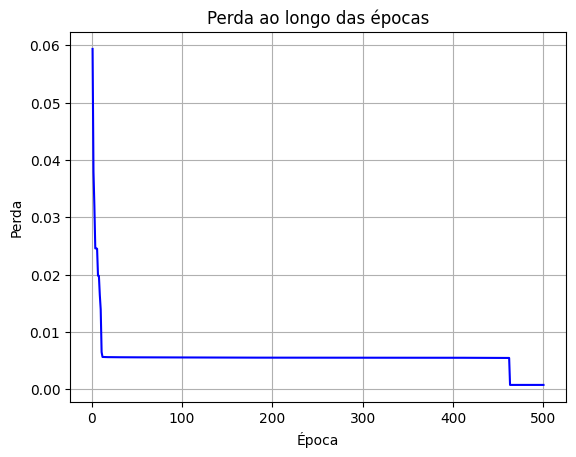

In [ ]:
# Criar gráfico de linha
plt.plot(epocas, perdas, color='blue', linestyle='-')
plt.title('Perda ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.grid(True)
plt.show()

##Exibição da Arquitetura do Autoencoder:
Nesta etapa, exibimos a arquitetura do autoencoder, fornecendo informações sobre o número de neurônios em cada camada. Isso é feito de forma simples, sem a criação de uma imagem da rede neural.

A visualização gráfica da arquitetura do autoencoder fornece uma representação mais intuitiva e compreensível da arquitetura da rede neural. A imagem resultante permite uma análise mais detalhada da estrutura da rede, facilitando a compreensão de como as camadas estão conectadas e quantos neurônios existem em cada camada.

Embora envolva um pouco mais de complexidade em comparação com uma representação textual simples, a imagem da rede neural oferece uma visualização mais rica e informativa da arquitetura.

###Criando uma representação visual da arquitetura do autoencoder usando uma imagem gráfica da rede neural

In [ ]:
class Grafico_Autoencoder:
    def __init__(self, camadas):
        self.camadas = camadas
        self.numero_de_camadas = len(camadas)

    def visualize(self):
        graph = pydot.Dot(graph_type='digraph')

        # Add nodes for each layer
        for i, size in enumerate(self.camadas):
            node = pydot.Node(f"Camada {i}\n{size} neurônios")
            graph.add_node(node)

        # Add edges between consecutive layers
        for i in range(self.numero_de_camadas - 1):
            edge = pydot.Edge(f"Camada {i}", f"Camada {i+1}")
            graph.add_edge(edge)

        return graph

In [ ]:
autoencoder = Grafico_Autoencoder(camadas)
autoencoder_visualization = autoencoder.visualize()

In [ ]:
autoencoder_visualization.write_png('autoencoder.png')

Nesta abordagem cada camada do autoencoder é mostrada como um nó na imagem, conectado por setas que representam as conexões entre as camadas.
Essa abordagem fornece uma representação visual da arquitetura, permitindo uma análise mais detalhada da estrutura da rede.

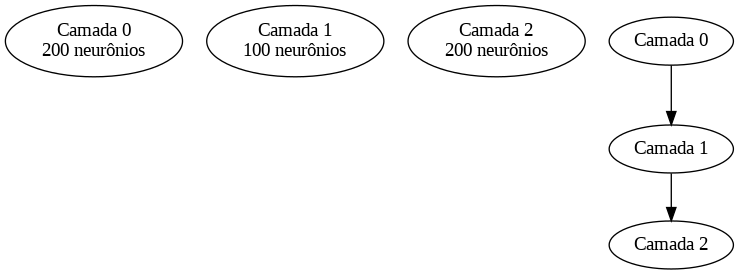

In [ ]:
Image('autoencoder.png')

##Visualização HTML da Rede Neural

Nesta etapa, criamos uma representação HTML da arquitetura do autoencoder para exibi-la de forma interativa em um ambiente de notebook. Isso oferece uma maneira conveniente de visualizar as camadas da rede neural.

In [ ]:
from IPython.display import display, HTML

class Grafico_Autoencoder2:
    def __init__(self, layer_sizes):
        self.camadas = camadas
        self.numero_de_camadas = len(camadas)

    def visualize(self):
        camadas_html = ""
        for i, size in enumerate(self.camadas):
            camadas_html += f"<div style='display: inline-block; padding: 10px; border: 1px solid black;'>Camada {i}<br>{size} neurônios</div>"
        return f"<div>{camadas_html}</div>"

autoencoder = Grafico_Autoencoder2(camadas)
autoencoder_visualization = autoencoder.visualize()

# Display the layers of the autoencoder
display(HTML(autoencoder_visualization))

Nesta abordagem, cada camada do autoencoder é representada como um bloco de texto dentro de uma página HTML, com informações sobre o número de neurônios em cada camada.
Essa abordagem oferece uma apresentação mais flexível e interativa da arquitetura, permitindo uma personalização avançada da aparência e do estilo da visualização.